**Data Preprocessing:**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

# Load dataset
# The original file likely has space-separated values and no header.
# Use delim_whitespace=True and header=None.
columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
df = pd.read_csv("housing.csv", delim_whitespace=True, names=columns)

# Check for missing values (optional but good practice)
print("Missing values before cleaning:")
print(df.isnull().sum())

# Convert relevant columns to numeric, coercing errors to NaN
# This step is crucial if the file has formatting issues that cause
# some values to be read as strings.
for col in columns:
    # Exclude 'CHAS' as it's likely categorical or already numeric
    # if it was read correctly. We primarily focus on potential
    # issues with continuous numeric columns.
    if col != 'CHAS':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# After coercing errors, check for newly introduced NaNs
print("\nMissing values after coercing to numeric:")
print(df.isnull().sum())

# Handle potential new NaNs, for example, by dropping rows or imputing
# For simplicity, let's drop rows with any NaNs introduced by coercion
df.dropna(inplace=True)

# Check data types to confirm columns are numeric
print("\nData types after cleaning:")
print(df.dtypes)

# Now we can proceed
# Separate features and target
X = df.drop(columns=["MEDV"])
y = df["MEDV"]

# Normalize numerical features
# This should now work as X contains only numeric data after cleaning
X = (X - X.mean()) / X.std()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

Missing values before cleaning:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Missing values after coercing to numeric:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Data types after cleaning:
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object


/tmp/ipython-input-5-227261501.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names=columns)


**Model Implementation:**

*  Linear Regression
*  Random Forest
*  XGBoost




In [6]:
class LinearRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            db = (1 / self.m) * np.sum(y_pred - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [7]:
from sklearn.tree import DecisionTreeRegressor

class RandomForestScratch:
    def __init__(self, n_estimators=10, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        max_feat = int(np.sqrt(n_features)) if self.max_features == 'sqrt' else n_features

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            features = np.random.choice(n_features, max_feat, replace=False)
            tree = DecisionTreeRegressor(max_depth=10)
            tree.fit(X[indices][:, features], y[indices])
            self.trees.append((tree, features))

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, feat]) for tree, feat in self.trees])
        return np.mean(tree_preds, axis=0)


In [9]:
class XGBoostScratch:
    def __init__(self, n_estimators=50, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        y_pred = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            model = DecisionTreeRegressor(max_depth=3)
            model.fit(X, residuals)
            update = model.predict(X)
            y_pred += self.learning_rate * update
            self.models.append(model)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        return y_pred


**Performance Comparison**

In [10]:
def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")
    return rmse, r2

# Train and evaluate Linear Regression
lr_model = LinearRegressionScratch()
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test, "Linear Regression")

# Train and evaluate Random Forest
rf_model = RandomForestScratch(n_estimators=20)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Train and evaluate XGBoost
xgb_model = XGBoostScratch(n_estimators=50)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


Linear Regression -> RMSE: 5.04, R2 Score: 0.65
Random Forest -> RMSE: 4.31, R2 Score: 0.75
XGBoost -> RMSE: 2.70, R2 Score: 0.90


(np.float64(2.6965576768458623), 0.900844835883354)

**Visualization:**

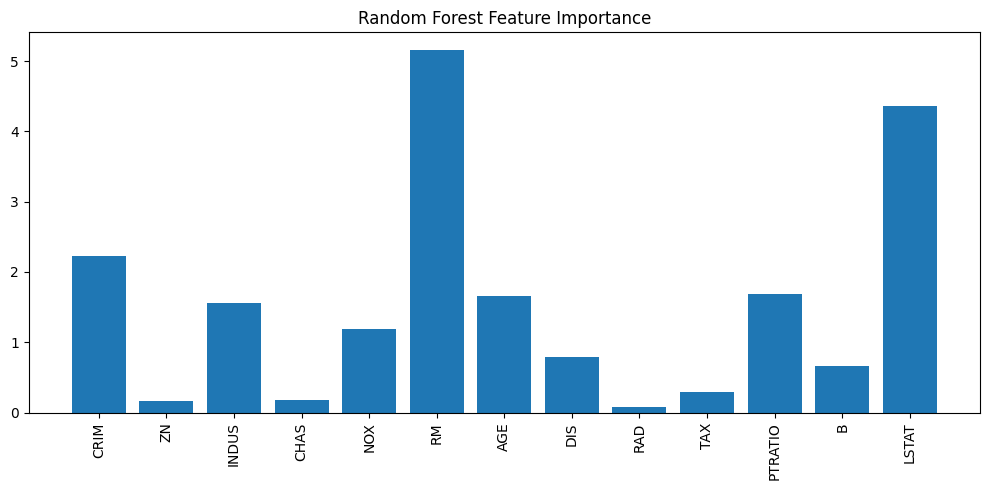

In [11]:
# For Random Forest
importances_rf = np.zeros(X.shape[1])
for tree, features in rf_model.trees:
    imp = tree.feature_importances_
    for i, f in enumerate(features):
        importances_rf[f] += imp[i]

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances_rf)
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
